In [1]:
%env CUDA_VISIBLE_DEVICES = 4

env: CUDA_VISIBLE_DEVICES=4


In [2]:
%load_ext autoreload
%autoreload 2
import sys; 
sys.path.extend(['/home/meet/FlowMatchingTests/conditional-flow-matching/'])

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchcfm.conditional_flow_matching import *
from physics_flow_matching.unet import UNetModel
from torchdiffeq import odeint
from einops import rearrange

In [3]:
label = np.load("/home/xiantao/case/wall_pressure/bigchannel/data/to_meet/channel_180_u_y70_all_out.npy")
# test_label = np.load("/home/xiantao/case/wall_pressure/bigchannel/data/to_meet/channel_180_u_y70_221-259_out.npy")
m, std = label.mean(axis=(0,2,3), keepdims=True), label.std(axis=(0,2,3), keepdims=True)
# Y = (test_label - m)/std
# test_label = rearrange(test_label, "b l c w -> (b c) l w")
# test_label = (test_label[:, 160:])[:, None]
# Y = (label - label.mean())/label.std()

In [4]:
test_label = label[36000:39900]

In [5]:
# l_d = label[:100]

In [6]:
data = np.load("/home/xiantao/case/wall_pressure/bigchannel/data/to_meet/channel_180_u_y40_all_out.npy") #np.load('/home/xiantao/case/wall_pressure/bigchannel/data/to_meet/channel_180_wall_dudy_all_out.npy') 
m_, std_ = data.mean(), data.std()

In [7]:
test_data = data[36000:39900]
# test_data = rearrange(test_data, "b l c w -> (b c) l w")
# test_data = (test_data[:, 160:])[:, None]
X = (test_data - m_)/std_

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
exp=5
iteration = 5
ot_cfm_model = UNetModel(dim=[1, 160, 200],
                        out_channels=1,
                        num_channels=128,
                        channel_mult = None,
                        num_res_blocks=2,
                        num_head_channels=64,
                        attention_resolutions="40, 20",
                        dropout=0.2,
                        use_new_attention_order=True,
                        use_scale_shift_norm=True)
state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/ws_vf/exps/exp_{exp}/saved_state/checkpoint_{iteration}.pth")
ot_cfm_model.load_state_dict(state["model_state_dict"])
ot_cfm_model.to(device)
ot_cfm_model.eval();

/tmp/ipykernel_3470621/624798182.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flo

In [10]:
batch_size=10

In [11]:
wall_norm_dict = {0:0}
key = 0

In [12]:
samples_list = []
for batch in range(X.shape[0]//batch_size):
    with torch.no_grad():
        out = ot_cfm_model(torch.tensor(wall_norm_dict[key]*np.ones(batch_size).astype(np.float32), device=device)[:, None], torch.tensor(X[batch*batch_size:(batch+1)*batch_size], device=device)).detach().cpu().numpy()
    out *= std[:, key]
    out += m[:, key]
    samples_list.append(out)

In [13]:
samples = np.concatenate(samples_list)[:, 0]

In [22]:
# samples = np.load("/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/ws_vf/exps/exp_5/y_0_samples_5epch_2.npy")

In [24]:
np.save(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/ws_vf/exps/exp_{exp}/y_{wall_norm_dict[key]}_samples_{iteration}epch_2", samples)

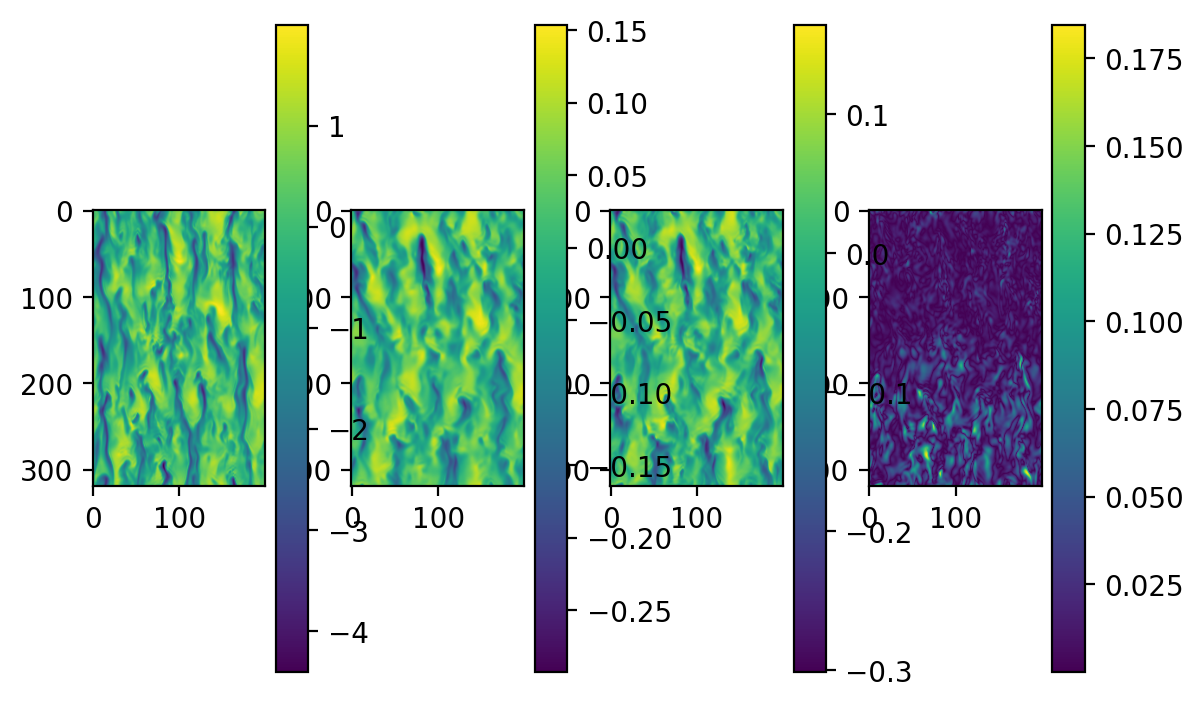

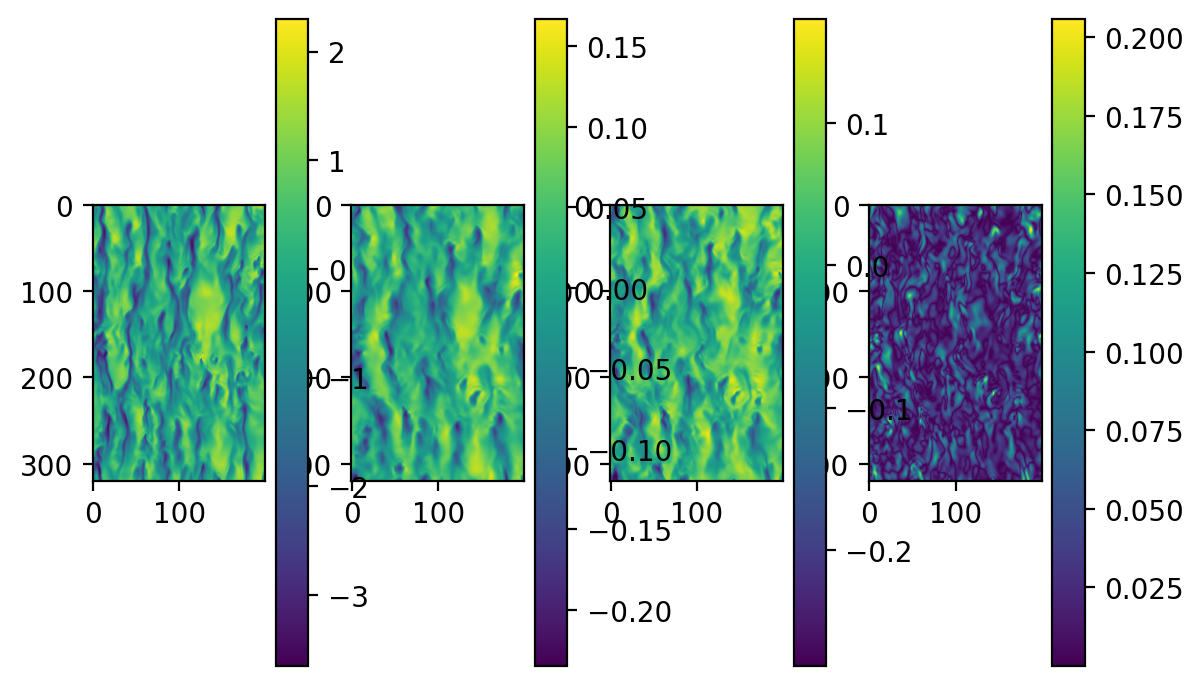

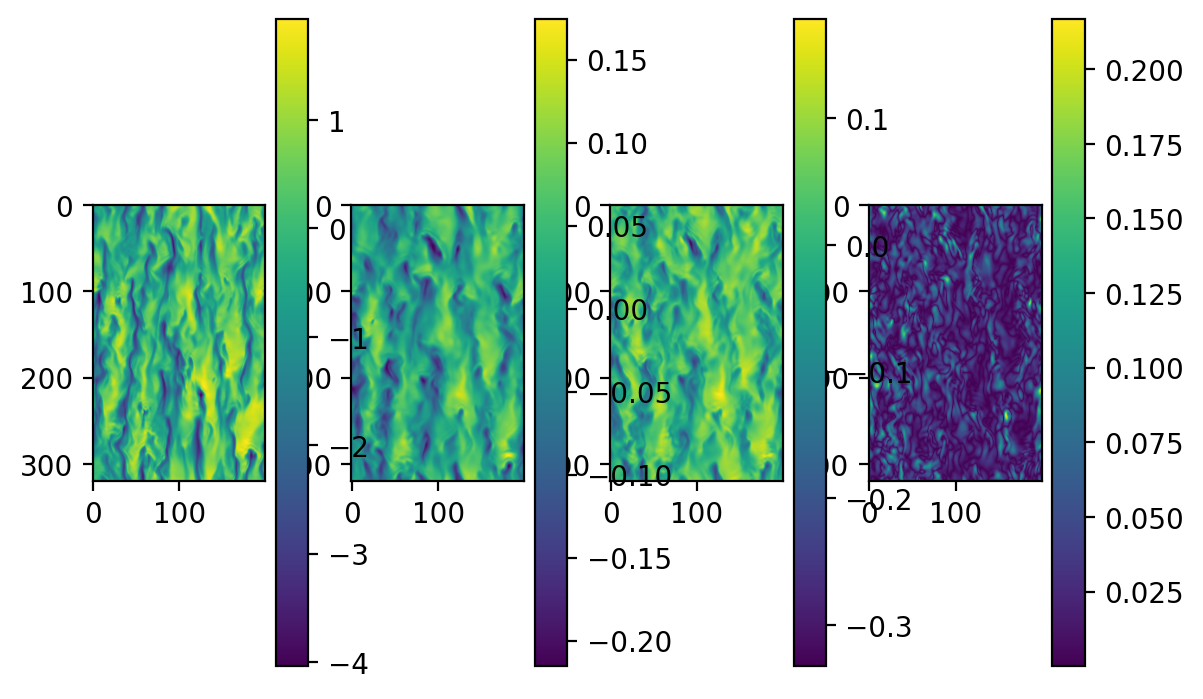

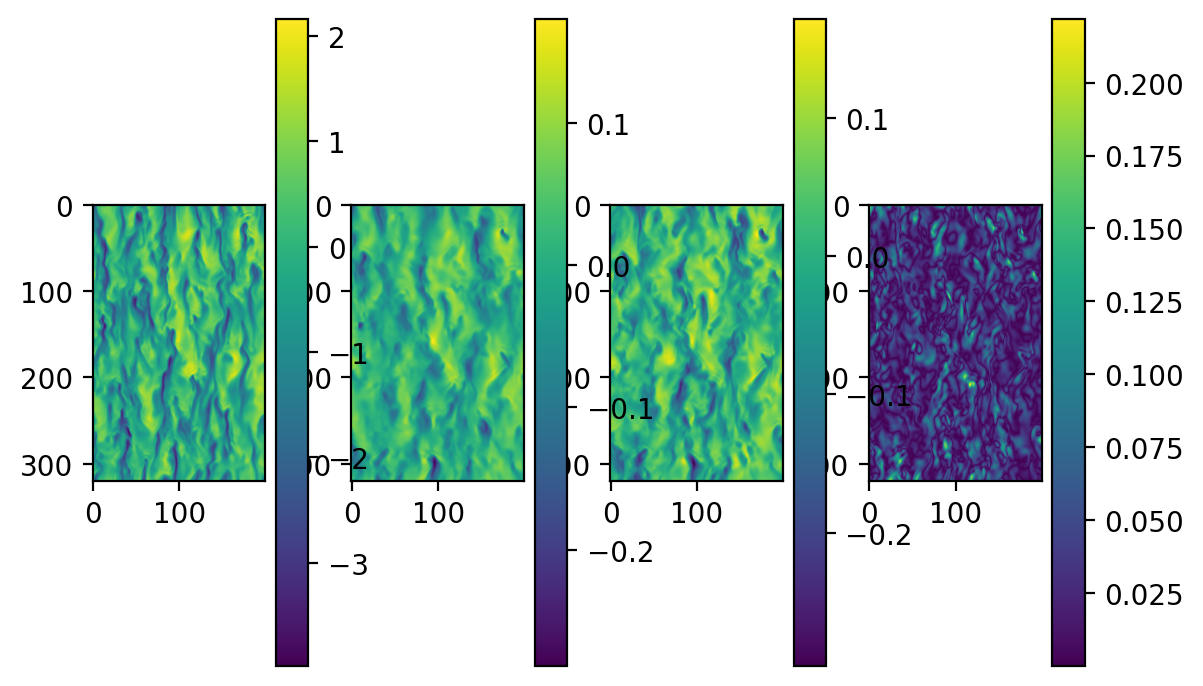

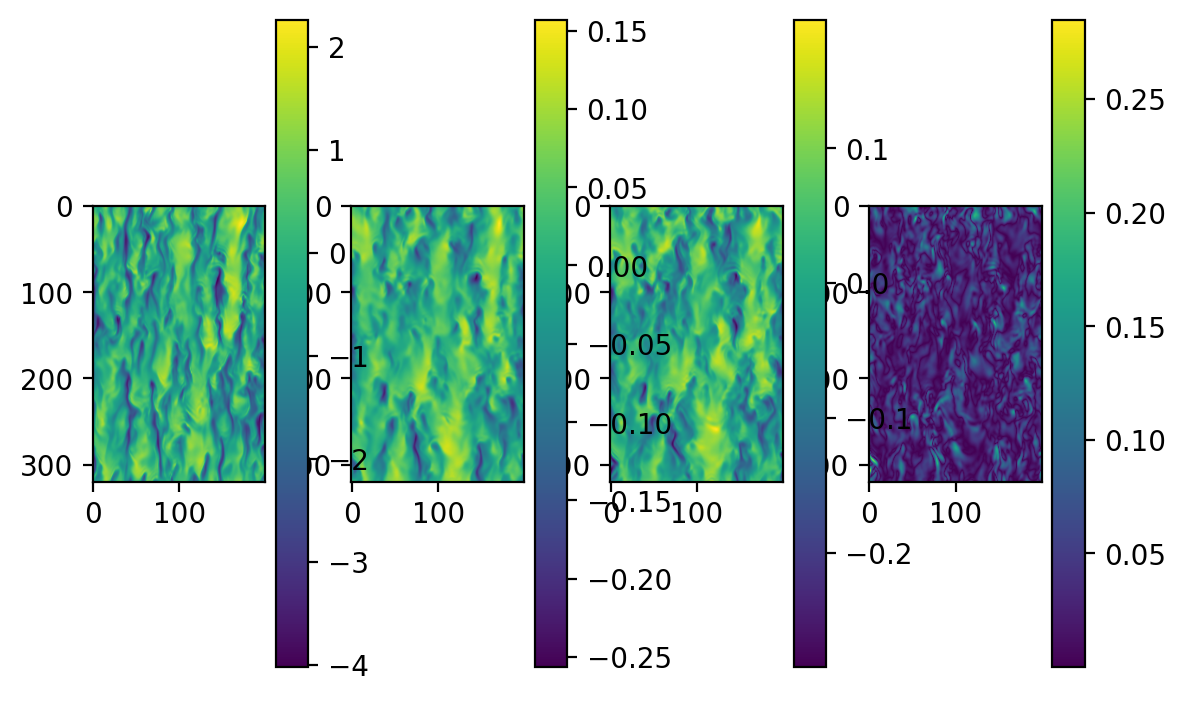

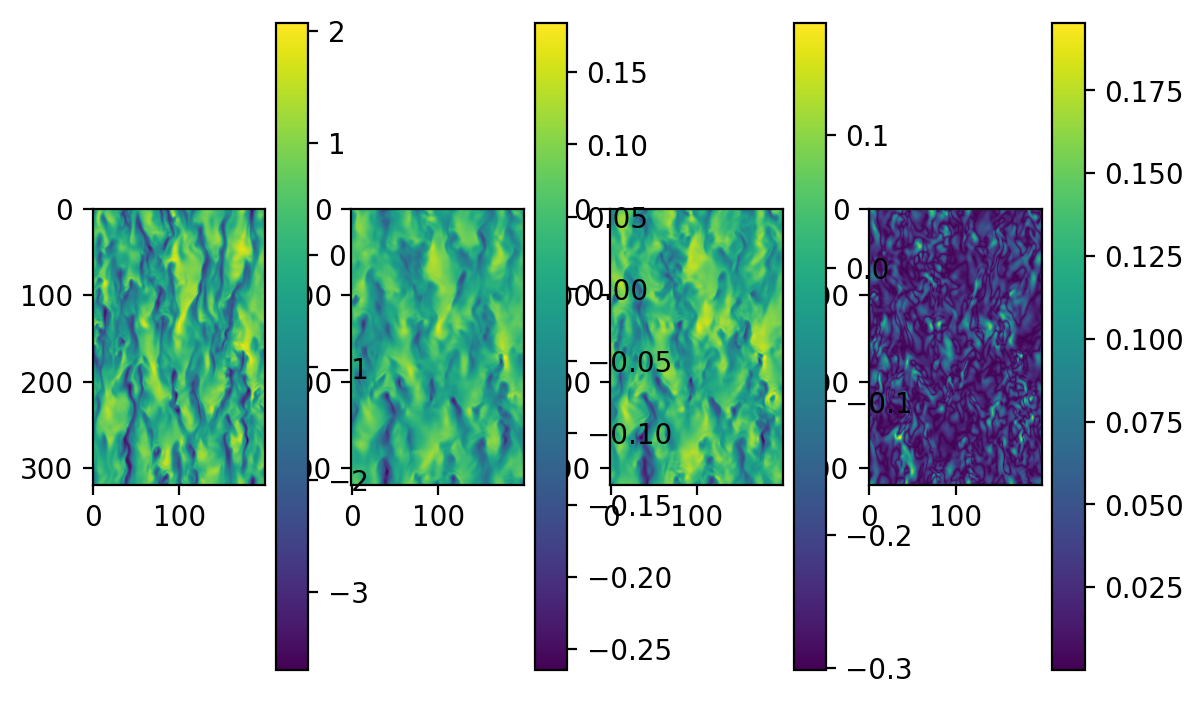

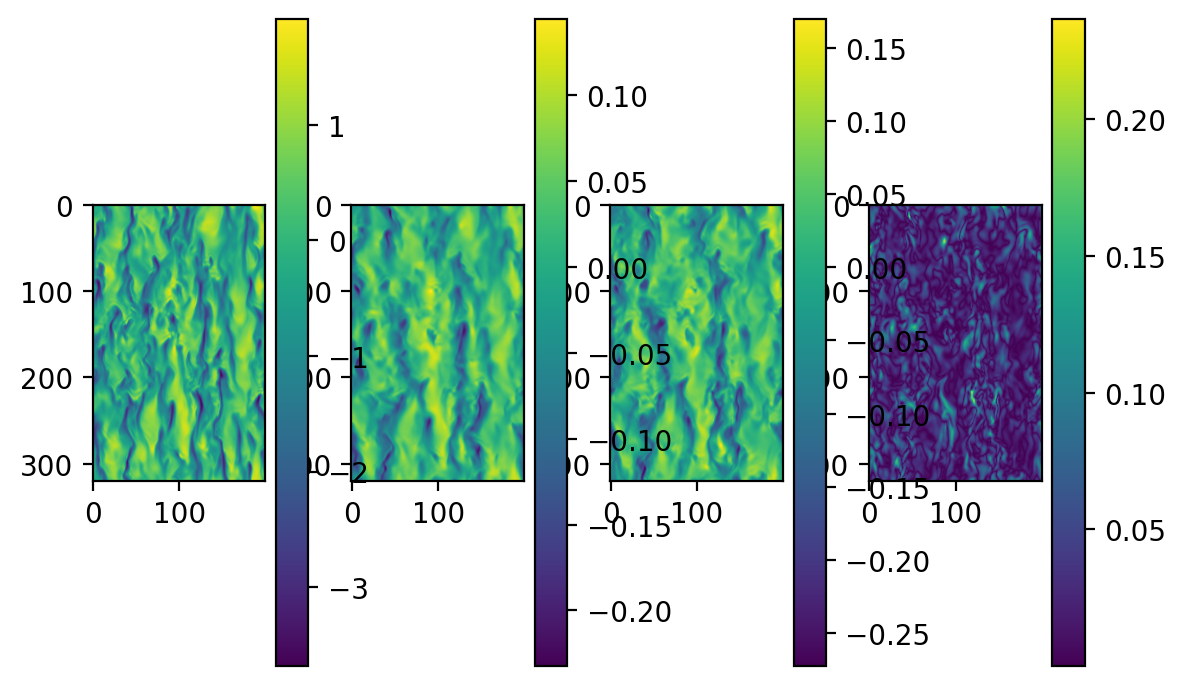

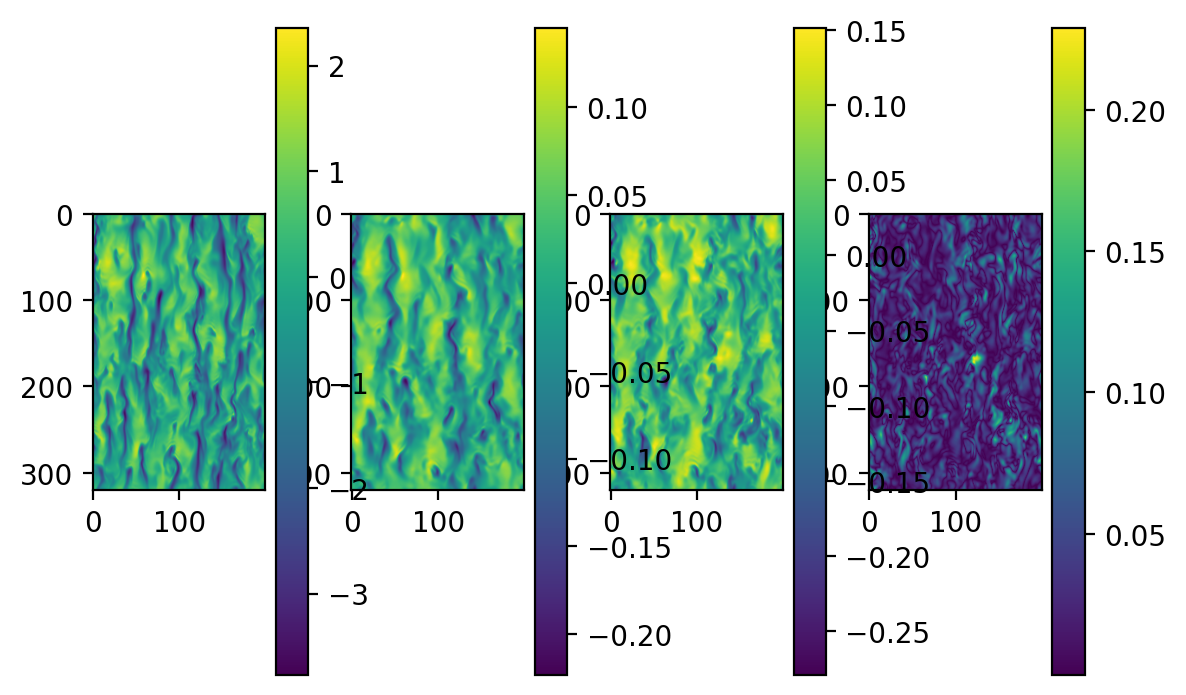

In [17]:
for i in range(0,4000,500):
    fig, axes = plt.subplots(nrows=1, ncols=4, dpi=200)
    ax = axes[0].imshow(X[i,0])
    plt.colorbar(ax,ax=axes[0])
    ax = axes[1].imshow(samples[i])
    plt.colorbar(ax,ax=axes[1])
    ax= axes[2].imshow(test_label[i, 0])
    plt.colorbar(ax,ax=axes[2])
    ax = axes[3].imshow(np.abs(samples[i] - test_label[i, 0]))
    plt.colorbar(ax,ax=axes[3])

In [2]:
# samples = np.load("/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/ws_vf/exps/exp_4/y_0_samples_5epch.npy")

In [20]:
# mean_error_train = np.mean(np.abs(samples_train - l_d[:, 0]), axis=(1,2))
mean_error = np.mean(np.abs(samples - test_label[:,0]), axis=(1,2))

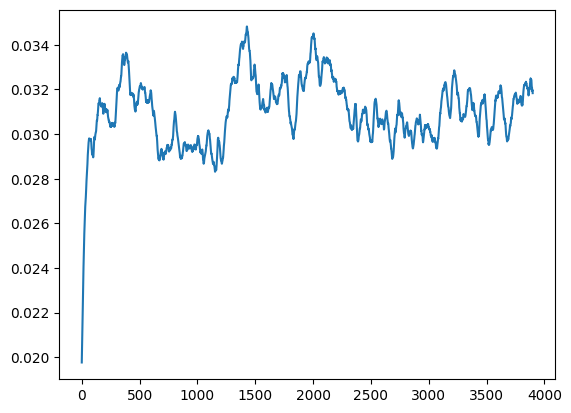

In [21]:
# plt.plot(mean_error_train)
plt.plot(mean_error)